Define the base cosmology, which is the Planck 2018 cosmology. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.cosmology import Planck18 as planck
import camb
from camb import model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# import colossus for HMF definition 
from colossus.cosmology import cosmology as cc
from colossus.lss import mass_function

/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Define baseline cosmology for `camb` $P_{\rm lin} (k)$ and the `colossus` HMF. 

In [3]:
pars = camb.set_params(H0=planck.H0.value, 
                       ombh2=planck.Ob0 * planck.h**2, 
                       omch2=planck.Odm0 * planck.h**2, 
                       mnu=planck.m_nu.value[-1], 
                       num_nu_massive = (planck.m_nu.value > 0).sum(),
                       omk=planck.Ok0, 
                       tau=0.0543, As=np.exp(3.0448)/10**10, ns=0.96605, #Plik best fit Planck 2018 Table 1 left-most col 1807.06209
                       halofit_version='mead', lmax=2000)

In [4]:
colossus_planck_cosmo = cc.fromAstropy(astropy_cosmo = planck, 
                      sigma8 = 0.809, # based on CAMB using the As 
                      ns = 0.96605, 
                      cosmo_name = 'planck_baseline')

/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/colossus/cosmology/cosmology.py:3338: UserWarning: Astropy cosmology class contains massive neutrinos, which are not taken into account in Colossus.
  warnings.warn('Astropy cosmology class contains massive neutrinos, which are not taken into account in Colossus.')


In [5]:
# set halo mass bins

# range from 10e7 to 10e15 to cover almost all CIB galaxies 
Mh = np.logspace(7, 15, 50)

In [6]:
# read in ELG dndz 
dndz = pd.read_csv("data/gal/elg_fuji_pz_single_tomo.csv")
z = dndz['Redshift_mid'].values
z_with_0 = np.zeros(len(z) + 1)
z_with_0[1:] = z

## Preprocess for ELGs

### Calculate $P_{\rm lin} (k)$

In [23]:
pars.set_matter_power(redshifts = z_with_0, kmax=10.0)

Note: redshifts have been re-sorted (earliest first)


class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 10.0
   k_per_logint = 0
   PK_num_redshifts = 31
   PK_redshifts = [2.950000000000001, 2.8500000000000014, 2.750000000000001, 2.650000000000001, 2.5500000000000007, 2.450000000000001, 2.3500000000000005, ...]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2150
 max_l_tensor = 600
 max_eta_k = 5375.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.0224178568132
 omch2 = 0.11934063901639999
 omk = 0.0
 omnuh2 = 0.000644866570625114
 H0 = 67.66
 TCMB = 2.7255
 YHe = 0.2458759299699272
 num_nu_massless = 2.0293333333333337
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0146666666

In [24]:
#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=3, 
                                              npoints = 400) #FIXME this is in units of little h

In [26]:
results.get_sigma8_0()

0.8093107469735158

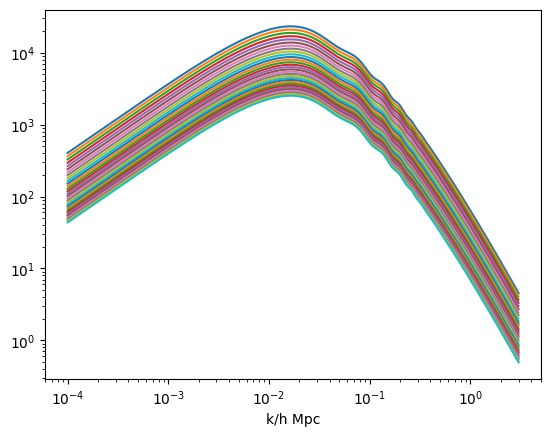

In [51]:
for i in range(len(z)):
    plt.loglog(kh, pk[i,:])
plt.xlabel('k/h Mpc');
#plt.legend(['linear','non-linear'], loc='lower left');
#plt.title('Matter power at z=%s and z= %s'%tuple(z));

In [29]:
# dictionary to store with relevant information 
plin_dict = {}

plin_dict['z'] = z
plin_dict['kh'] = kh
plin_dict['pk'] = pk

In [30]:
with open('data/plin_unit_h.p', 'wb') as handle:
    pickle.dump(plin_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Calculate HMF (z)

In [7]:
from colossus.lss import mass_function

In [8]:
cc.setCurrent(colossus_planck_cosmo) # set cosmology defn

hmfz = np.zeros((len(z), len(Mh))) #HMF of shape (z, Mh)

for i in range(len(z)):
    hmfz[i] = mass_function.massFunction(x = Mh,
                           z = z[i],
                           mdef = '200m',
                           model = 'tinker08',
                           q_in = 'M',
                           q_out = 'dndlnM')

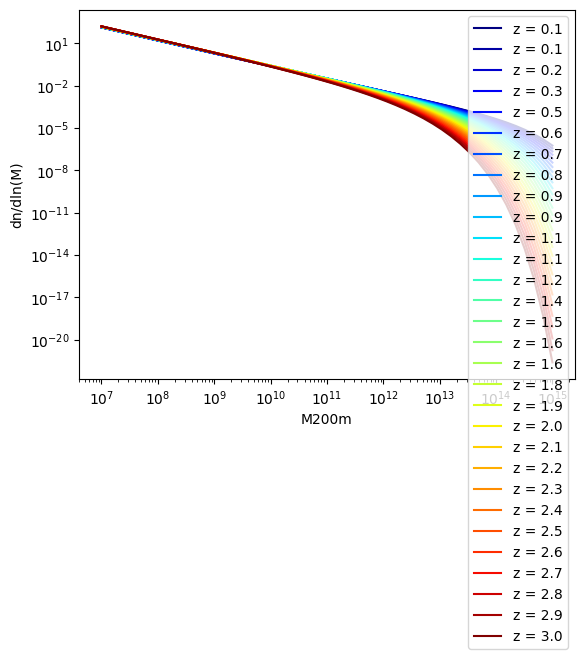

In [10]:
plt.xlabel('M200m')
plt.ylabel('dn/dln(M)')

colors = plt.cm.jet(np.linspace(0,1,len(z)))
for i in range(len(z)):
    plt.loglog(Mh, hmfz[i], '-', label = 'z = %.1f' % (z[i]),
             color = colors[i])
plt.legend();

In [29]:
# save hmf dictionary information
hmfz_dict = {}
hmfz_dict['z'] = z
hmfz_dict['Mh'] = Mh
hmfz_dict['hmfz'] = hmfz

In [31]:
with open('data/hmfz.p', 'wb') as handle:
    pickle.dump(hmfz_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Test codes

In [2]:
import cib
import consts
import matplotlib.pyplot as plt
import numpy as np

/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
z = consts.dict_gal['ELG']['z']

Text(0.5, 0, 'z')

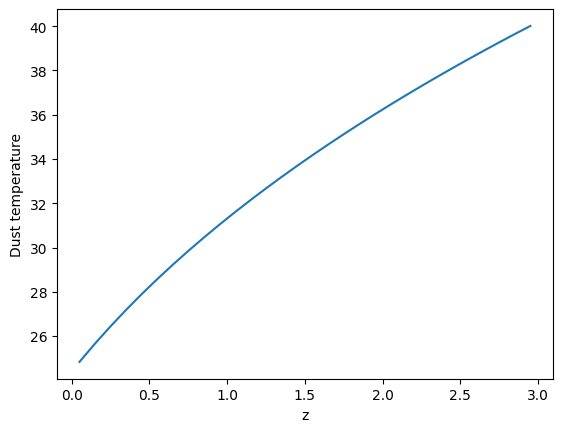

In [4]:
Td = cib.Tdust(z)
plt.plot(z, Td)
plt.ylabel("Dust temperature")
plt.xlabel("z")

In [5]:
nu_list = np.array([100, 143, 217, 353, 545, 857, 3000]) * 1e9  
nu_list

array([1.00e+11, 1.43e+11, 2.17e+11, 3.53e+11, 5.45e+11, 8.57e+11,
       3.00e+12])

In [7]:
Bnu_all = cib.B_nu(nu_list, Td)

Text(0, 0.5, 'Planck Function')

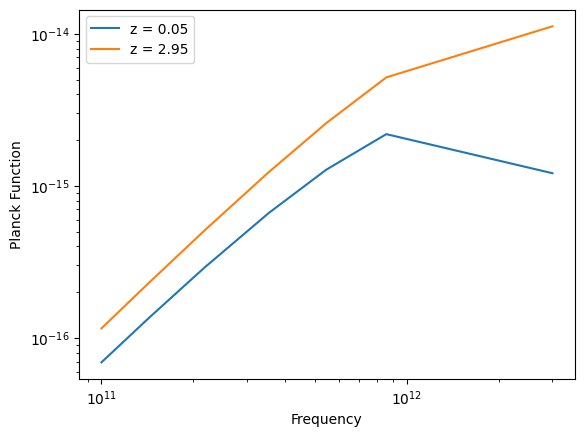

In [15]:
plt.loglog(nu_list, Bnu_all.T[0], label = f'z = {z[0]}')
plt.loglog(nu_list, Bnu_all.T[-1], label = f'z = {np.round(z[-1],2)}')
plt.legend(loc = 'best')
plt.xlabel("Frequency")
plt.ylabel("Planck Function")

In [49]:
tst_nu = np.logspace(6, 19, 1000)
Bnu = cib.B_nu(tst_nu, Td[10])

/Users/tkarim/Documents/research/cib.nosync/cib.py:56: RuntimeWarning: overflow encountered in exp
  x = (hp*nu)/(kB*Td)


(1e-24, 0.0001)

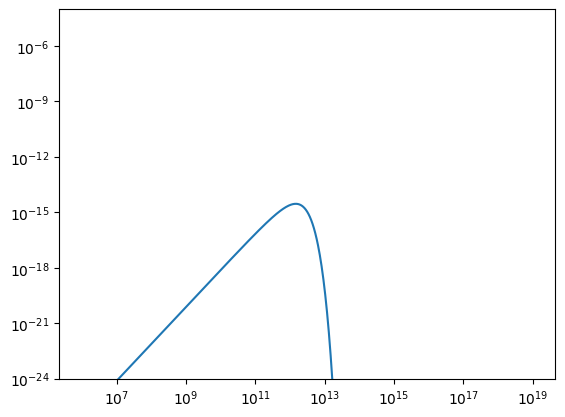

In [11]:
plt.loglog(tst_nu, Bnu)
plt.ylim([10e-25, 10e-5])

In [64]:
from astropy.io import fits

In [88]:
hdu = fits.open("data/filtered_snu_planck.fits")
wavelengths = np.loadtxt('data/TXT_TABLES_2015/EffectiveSED_B15_z0.012.txt')[:, [0]]

In [73]:
hdu[0].data

array([[1.26552135e-13, 3.47169099e-14, 1.51488574e-14, ...,
        5.57081231e-17, 5.65057599e-17, 5.75917015e-17],
       [2.26060663e-13, 6.26579312e-14, 2.76262871e-14, ...,
        1.41497839e-16, 1.42573896e-16, 1.44361516e-16],
       [7.30234004e-13, 2.03957385e-13, 9.05777273e-14, ...,
        3.34219674e-16, 3.32484995e-16, 3.31770905e-16],
       ...,
       [1.24239228e-11, 3.47058399e-12, 1.54154448e-12, ...,
        3.45019143e-16, 3.32928027e-16, 3.22691994e-16],
       [4.41938982e-11, 1.23156925e-11, 5.45570863e-12, ...,
        1.24409126e-16, 1.16572211e-16, 1.09734988e-16],
       [2.14144690e-10, 5.75534734e-11, 2.45899325e-11, ...,
        9.38288598e-18, 9.46975216e-18, 9.09417234e-18]])

In [76]:
redshifts = hdu[1].data
snu_eff = hdu[0].data  # in Jy/Lsun

In [77]:
redshifts.shape

(210,)

In [78]:
snu_eff.shape

(7, 210)

In [81]:
snu_eff.T[0]

array([1.26552135e-13, 2.26060663e-13, 7.30234004e-13, 3.27709454e-12,
       1.24239228e-11, 4.41938982e-11, 2.14144690e-10])

In [86]:
hdu[2].data

array([3.13921105e+10, 3.28716196e+10, 3.44208030e+10, 3.60430144e+10,
       3.77416455e+10, 3.95203728e+10, 4.13828769e+10, 4.33331924e+10,
       4.53754555e+10, 4.75139285e+10, 4.97531296e+10, 5.20979525e+10,
       5.45532468e+10, 5.71243253e+10, 5.98164873e+10, 6.26355343e+10,
       6.55874707e+10, 6.86784581e+10, 7.19152679e+10, 7.53044930e+10,
       7.88535328e+10, 8.25697117e+10, 8.64610520e+10, 9.05359081e+10,
       9.48026291e+10, 9.92706694e+10, 1.03949147e+11, 1.08848011e+11,
       1.13977827e+11, 1.19349358e+11, 1.24974449e+11, 1.30864020e+11,
       1.37031694e+11, 1.43489426e+11, 1.50252327e+11, 1.57333378e+11,
       1.64748287e+11, 1.72512636e+11, 1.80642483e+11, 1.89156634e+11,
       1.98071076e+11, 2.07405674e+11, 2.17181108e+11, 2.27415273e+11,
       2.38132746e+11, 2.49357425e+11, 2.61109139e+11, 2.73413521e+11,
       2.86299178e+11, 2.99792458e+11, 3.13921105e+11, 3.28715836e+11,
       3.44208030e+11, 3.60430144e+11, 3.77416455e+11, 3.95203728e+11,
      

In [90]:
nu0min = 50.  # nucen-deltanu/2.
nu0max = 3000.  # nucen+deltanu/2.
steps = 20  # 2000 nu0max-nu0min+1  # nu0max-nu0min+1  # 200
nu0 = np.linspace(nu0min, nu0max, int(steps))

In [83]:
import glob

In [84]:
list_of_files = sorted(glob.glob('./data/TXT_TABLES_2015/./*.txt'))

In [91]:
for i in range(len(list_of_files)):
    print(list_of_files[i][-9:-4])

0.012
0.023
0.035
0.047
0.059
0.072
0.084
0.096
0.109
0.122
0.135
0.148
0.161
0.175
0.189
0.202
0.216
0.230
0.245
0.259
0.274
0.288
0.303
0.318
0.334
0.349
0.365
0.380
0.396
0.413
0.429
0.445
0.462
0.479
0.496
0.514
0.531
0.549
0.567
0.585
0.603
0.622
0.641
0.660
0.679
0.698
0.718
0.738
0.758
0.778
0.799
0.820
0.841
0.862
0.884
0.905
0.928
0.950
0.972
0.995
1.018
1.042
1.065
1.089
1.113
1.138
1.163
1.188
1.213
1.239
1.265
1.291
1.317
1.344
1.371
1.399
1.427
1.455
1.483
1.512
1.541
1.570
1.600
1.630
1.661
1.692
1.723
1.754
1.786
1.818
1.851
1.884
1.917
1.951
1.985
0.092
0.220
2.020
2.055
2.090
2.126
2.162
2.199
2.236
2.273
2.311
2.350
2.388
2.428
2.467
2.508
2.548
2.589
2.631
2.673
2.715
2.758
2.802
2.846
2.890
2.936
2.981
3.027
3.074
3.121
3.169
3.217
3.266
3.315
3.365
3.416
3.467
3.519
3.571
3.624
3.677
3.732
3.786
3.842
3.898
3.955
4.012
4.070
4.129
4.188
4.248
4.309
4.370
4.433
4.495
4.559
4.623
4.689
4.754
4.821
4.888
4.957
5.026
5.095
5.166
5.237
5.310
5.383
5.457
5.531
5.607
5.68

In [30]:
a = list_of_files[95] #FIXME: why 95 and 96
b = list_of_files[96]

for i in range(95, 208): #FIXME: why this range 
    list_of_files[i] = list_of_files[i+2]
list_of_files[208] = a
list_of_files[209] = b

In [32]:
wavelengths = np.loadtxt('./data/TXT_TABLES_2015/EffectiveSED_B15_z0.012.txt')[:, [0]]

In [34]:
freq = 300000/wavelengths # in km/s

In [36]:
numerical_fac = 1.
freqhz = freq*1e3*1e6
freq *= numerical_fac

In [38]:
np.size(wavelengths)

200

In [41]:
len(wavelengths)

200

In [48]:
dndz = pd.read_csv("data/gal/elg_fuji_pz_single_tomo.csv")
z = dndz['Redshift_mid'].values

freq_rest = freqhz*(1 + z)

In [65]:
n = len(wavelengths) # number of wavelength bins 
n

200

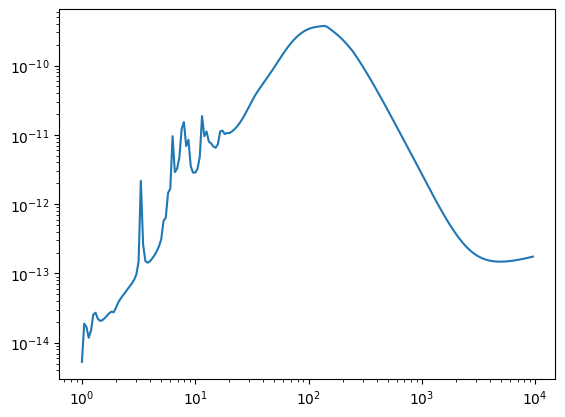

In [80]:
tmp = np.loadtxt(list_of_files[0])
plt.loglog(tmp[:,0], tmp[:,1])

In [66]:
snu_unfiltered = np.zeros([n, len(z)])

for i in range(len(list_of_files)):
    snu_unfiltered[:, i] = np.loadtxt(list_of_files[i])[:, 1]

IndexError: index 30 is out of bounds for axis 1 with size 30

In [72]:
len(list_of_files)

210

In [82]:
import consts

In [4]:
import numpy as np
import gal_prop as gp
import precalculation as pc
import consts
import matplotlib.pyplot as plt

/Users/tkarim/Documents/research/cib.nosync/gal_prop.py:84: RuntimeWarning: invalid value encountered in power
  return As * power_term**alpha


In [7]:
z = consts.dict_gal['ELG']['z']

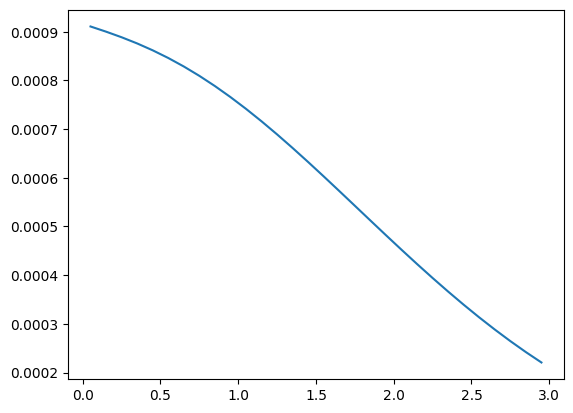

In [8]:
plt.plot(z, pc.nbar_gal)

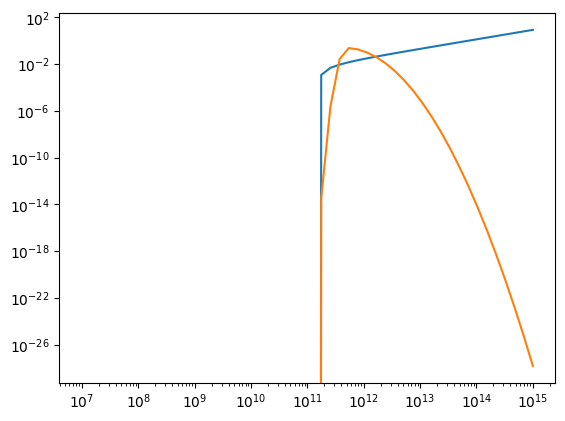

In [9]:
plt.plot(pc.Mh, pc.Nsat)
plt.plot(pc.Mh, pc.Ncen)
plt.xscale("log")
plt.yscale("log")

/Users/tkarim/Documents/research/cib.nosync/gal_prop.py:83: RuntimeWarning: invalid value encountered in power
  return As * power_term**alpha


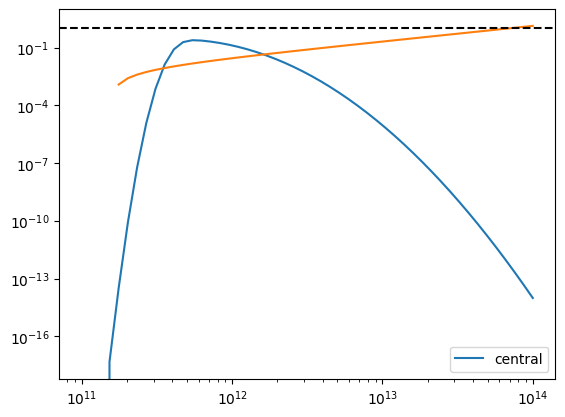

In [52]:
plt.plot(Mh, gp.Ncen(Mh), label = 'central')
plt.plot(Mh, gp.Nsat(Mh))
plt.legend(loc = 'best')
plt.xscale("log")
plt.yscale("log")
plt.axhline(1, c = 'k', ls = '--')

In [28]:
np.log10(Mh) - 11.83

array([-1.83      , -1.74836735, -1.66673469, -1.58510204, -1.50346939,
       -1.42183673, -1.34020408, -1.25857143, -1.17693878, -1.09530612,
       -1.01367347, -0.93204082, -0.85040816, -0.76877551, -0.68714286,
       -0.6055102 , -0.52387755, -0.4422449 , -0.36061224, -0.27897959,
       -0.19734694, -0.11571429, -0.03408163,  0.04755102,  0.12918367,
        0.21081633,  0.29244898,  0.37408163,  0.45571429,  0.53734694,
        0.61897959,  0.70061224,  0.7822449 ,  0.86387755,  0.9455102 ,
        1.02714286,  1.10877551,  1.19040816,  1.27204082,  1.35367347,
        1.43530612,  1.51693878,  1.59857143,  1.68020408,  1.76183673,
        1.84346939,  1.92510204,  2.00673469,  2.08836735,  2.17      ])

In [29]:
import scipy.special as ss

In [54]:
from colossus.lss import mass_function

In [56]:
from colossus.cosmology import cosmology as cc

In [58]:
cc.setCosmology('planck18')

In [71]:
hmf = mass_function.massFunction(Mh,
                           ,
                           q_in='M',
                           q_out='dndlnM',
                           model='tinker08',
                           mdef='200m')

TypeError: unsupported operand type(s) for +: 'float' and 'list'

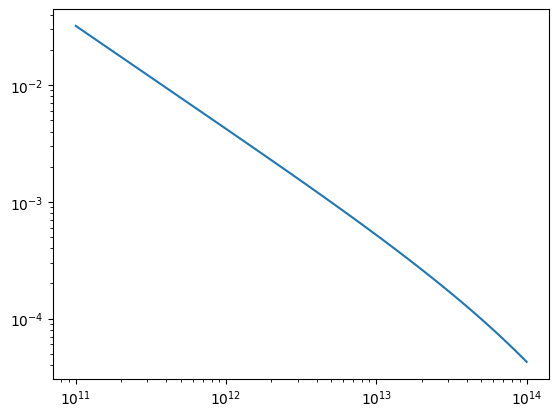

In [70]:
plt.loglog(Mh, hmf)